## preparation

In [11]:
import numpy as np
import networkx as nx
from scipy.stats import entropy
import matplotlib.pyplot as plt
import random
import string

%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
from func.EI_calculation import tpm_ei
from func.p_calculation import calculate_or_p
from func.p_calculation import calculate_xor_p
from func.p_calculation import noise_modify_p

In [12]:
%run EI_calculation.ipynb

In [13]:
%run p_calculation.ipynb

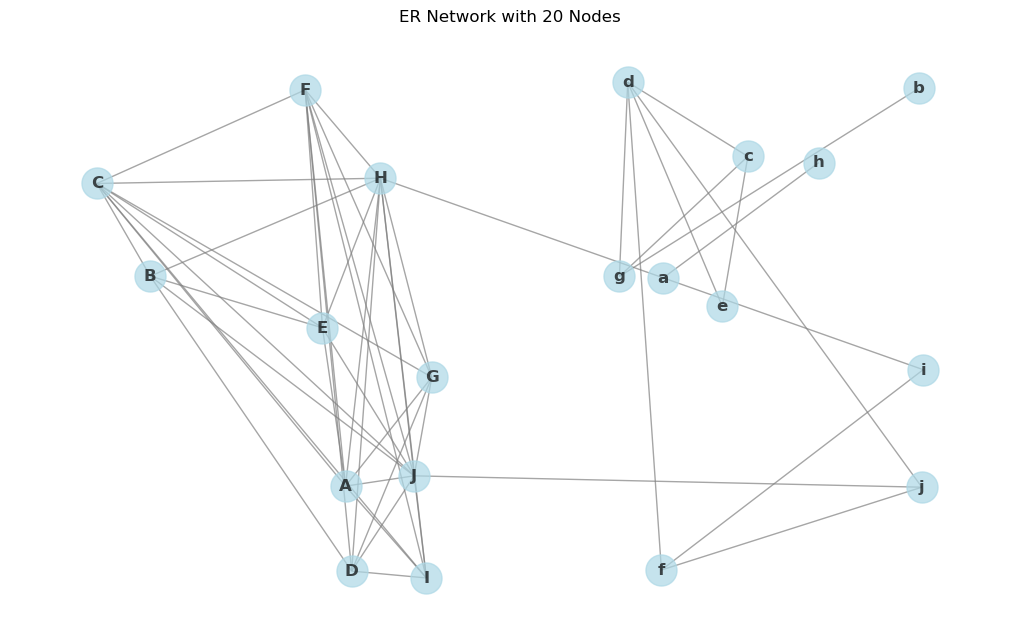

In [14]:
random.seed(26)
G = nx.Graph()

# 添加32个节点，分别命名为大写字母和小写字母
upper_nodes = list(string.ascii_uppercase)[:10]
lower_nodes = list(string.ascii_lowercase)[:10]
G.add_nodes_from(upper_nodes)
G.add_nodes_from(lower_nodes)

pos = {}  # 定义节点的位置
radius = 10  # 圆的半径

for i, node in enumerate(upper_nodes):   # 左边圆形排列
    angle = 2 * 3.141592653589793 * i / 10
    x = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 1
    y = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 1
    pos[node] = (x, y)

for i, node in enumerate(lower_nodes):   # 右边圆形排列
    angle = 2 * 3.141592653589793 * i / 10
    x = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 4
    y = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 1
    pos[node] = (x, y)

for u in upper_nodes:   # 根据概率添加边
    for v in upper_nodes:
        if u != v and random.random() <= 0.5:
            G.add_edge(u, v)
for u in lower_nodes:
    for v in lower_nodes:
        if u != v and random.random() <= 0.1:
            G.add_edge(u, v)

for i in range(2):   # 在两个圆之间增加2条连边
    u = random.choice(upper_nodes)
    v = random.choice(lower_nodes)
    G.add_edge(u, v)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_color='black', font_weight='bold', edge_color='gray', width=1.0, alpha=0.7)
plt.title('ER Network with 20 Nodes')
plt.show()

In [15]:
# 创建存储节点信息的字典
node_info1 = {}

# 给每个节点按顺序编号，并存储邻居信息
node_to_index1 = {node: i for i, node in enumerate(upper_nodes + lower_nodes)}

for node in sorted(G.nodes()):
    neighbors_indices = [node_to_index1[neighbor] for neighbor in sorted(G.neighbors(node))]
    node_info1[node] = { 'index': node_to_index1[node], 'neighbors': neighbors_indices }

# 输出节点信息到控制台
for node, info in sorted(node_info1.items()):
    print(f"Node {node}: Index = {info['index']}, Neighbors = {info['neighbors']}")


Node A: Index = 0, Neighbors = [2, 4, 5, 6, 7, 8, 9]
Node B: Index = 1, Neighbors = [2, 3, 4, 7, 9]
Node C: Index = 2, Neighbors = [0, 1, 4, 5, 6, 7, 8, 9]
Node D: Index = 3, Neighbors = [1, 5, 6, 7, 8, 9]
Node E: Index = 4, Neighbors = [0, 1, 2, 5, 7, 9]
Node F: Index = 5, Neighbors = [0, 2, 3, 4, 6, 7, 8, 9]
Node G: Index = 6, Neighbors = [0, 2, 3, 5, 7, 9]
Node H: Index = 7, Neighbors = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
Node I: Index = 8, Neighbors = [0, 2, 3, 5, 7, 9]
Node J: Index = 9, Neighbors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
Node a: Index = 10, Neighbors = [7, 17, 18]
Node b: Index = 11, Neighbors = [16]
Node c: Index = 12, Neighbors = [13, 14, 16]
Node d: Index = 13, Neighbors = [12, 14, 15, 16, 19]
Node e: Index = 14, Neighbors = [12, 13]
Node f: Index = 15, Neighbors = [13, 18, 19]
Node g: Index = 16, Neighbors = [11, 12, 13]
Node h: Index = 17, Neighbors = [10]
Node i: Index = 18, Neighbors = [10, 15]
Node j: Index = 19, Neighbors = [9, 13, 15]


In [16]:
# 创建存储节点信息的字典
node_info2 = {}

# 给每个节点按顺序编号，并存储邻居信息
node_to_index2 = {node: i for i, node in enumerate(lower_nodes + upper_nodes)}

for node in sorted(G.nodes()):
    neighbors_indices = [node_to_index2[neighbor] for neighbor in sorted(G.neighbors(node))]
    node_info2[node] = { 'index': node_to_index2[node], 'neighbors': neighbors_indices }

# 输出节点信息到控制台
for node, info in sorted(node_info2.items()):
    print(f"Node {node}: Index = {info['index']}, Neighbors = {info['neighbors']}")


Node A: Index = 10, Neighbors = [12, 14, 15, 16, 17, 18, 19]
Node B: Index = 11, Neighbors = [12, 13, 14, 17, 19]
Node C: Index = 12, Neighbors = [10, 11, 14, 15, 16, 17, 18, 19]
Node D: Index = 13, Neighbors = [11, 15, 16, 17, 18, 19]
Node E: Index = 14, Neighbors = [10, 11, 12, 15, 17, 19]
Node F: Index = 15, Neighbors = [10, 12, 13, 14, 16, 17, 18, 19]
Node G: Index = 16, Neighbors = [10, 12, 13, 15, 17, 19]
Node H: Index = 17, Neighbors = [10, 11, 12, 13, 14, 15, 16, 18, 19, 0]
Node I: Index = 18, Neighbors = [10, 12, 13, 15, 17, 19]
Node J: Index = 19, Neighbors = [10, 11, 12, 13, 14, 15, 16, 17, 18, 9]
Node a: Index = 0, Neighbors = [17, 7, 8]
Node b: Index = 1, Neighbors = [6]
Node c: Index = 2, Neighbors = [3, 4, 6]
Node d: Index = 3, Neighbors = [2, 4, 5, 6, 9]
Node e: Index = 4, Neighbors = [2, 3]
Node f: Index = 5, Neighbors = [3, 8, 9]
Node g: Index = 6, Neighbors = [1, 2, 3]
Node h: Index = 7, Neighbors = [0]
Node i: Index = 8, Neighbors = [0, 5]
Node j: Index = 9, Neighbo

In [17]:
def same_or_ei(degree):
    global Col
    ei_results = {}  # 用于存储结果的字典
    total_combinations = 2 ** (degree - 1) # 计算组合总数
    all_A_matrices = []  # 用于存储所有A矩阵的列表
    for m in range(total_combinations):
        binary_str = f'{m:0{degree}b}'  # 生成相应长度的二进制字符串
        Col = [binary_str, '1' + binary_str[1:]]  # 创建 'Col' 变量
        A = np.empty((2, 2))  # 初始化一个 2x2 的空数组
        params = tuple(range(degree))  # 根据 bit_length 动态生成参数列表
        for i in range(A.shape[0]):
            A[i] = calculate_or_p(i, *params)  # 动态传入参数
        all_A_matrices.append(A)  # 将当前A矩阵添加到列表中
        ei = tpm_ei(A, log_base=2)
        nei = binary_str[1:]
        ei_results[nei] = ei 
    average_A_matrix = np.mean(all_A_matrices, axis=0) 
    return ei_results, average_A_matrix

In [18]:
def calculate_average(ei_results):
    total_sum = sum(ei_results.values())  # 计算所有值的总和
    count = len(ei_results)  # 计算字典中键值对的数量
    average = total_sum / count if count != 0 else 0  # 计算平均数，避免除以零
    return average

In [19]:
structure_or_result = {}

## dense

In [20]:
# 外部2个节点为00
Col = ['{:010b}00'.format(i) for i in range(2**10)]
dense00 = np.empty((2**10, 2**10))
for i in range(dense00.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense00[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [21]:
# 外部2个节点为01
Col = ['{:010b}01'.format(i) for i in range(2**10)]
dense01 = np.empty((2**10, 2**10))
for i in range(dense01.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense01[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [22]:
# 外部2个节点为10
Col = ['{:010b}10'.format(i) for i in range(2**10)]
dense10 = np.empty((2**10, 2**10))
for i in range(dense10.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense10[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [23]:
# 外部2个节点为11
Col = ['{:010b}11'.format(i) for i in range(2**10)]
dense11 = np.empty((2**10, 2**10))
for i in range(dense11.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense11[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [24]:
dense_00_ei = tpm_ei(dense00, log_base = 2)
dense_01_ei = tpm_ei(dense01, log_base = 2)
dense_10_ei = tpm_ei(dense10, log_base = 2)
dense_11_ei = tpm_ei(dense11, log_base = 2)

dense_aj_ei = (dense_00_ei + dense_01_ei + dense_10_ei + dense_11_ei) / 4

In [25]:
structure_or_result['dense_00_ei'] = dense_00_ei
structure_or_result['dense_01_ei'] = dense_01_ei
structure_or_result['dense_10_ei'] = dense_10_ei
structure_or_result['dense_11_ei'] = dense_11_ei

structure_or_result['dense_aj_ei'] = dense_aj_ei

In [26]:
dense = np.mean([dense00, dense01, dense10, dense11], axis=0)

In [27]:
dense_ei = tpm_ei(dense, log_base = 2)

In [28]:
structure_or_result['dense_ei'] = dense_ei
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464)}

## thin

In [29]:
# 外部2个节点为00
Col = ['{:010b}00'.format(i) for i in range(2**10)]
thin00 = np.empty((2**10, 2**10))
for i in range(thin00.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin00[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [30]:
# 外部2个节点为01
Col = ['{:010b}01'.format(i) for i in range(2**10)]
thin01 = np.empty((2**10, 2**10))
for i in range(thin01.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin01[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [31]:
# 外部2个节点为10
Col = ['{:010b}10'.format(i) for i in range(2**10)]
thin10 = np.empty((2**10, 2**10))
for i in range(thin10.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin10[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [32]:
# 外部2个节点为11
Col = ['{:010b}11'.format(i) for i in range(2**10)]
thin11 = np.empty((2**10, 2**10))
for i in range(thin11.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin11[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [33]:
thin_00_ei = tpm_ei(thin00, log_base = 2)
thin_01_ei = tpm_ei(thin01, log_base = 2)
thin_10_ei = tpm_ei(thin10, log_base = 2)
thin_11_ei = tpm_ei(thin11, log_base = 2)

thin_HJ_ei = (thin_00_ei + thin_01_ei + thin_10_ei + thin_11_ei) / 4

In [34]:
structure_or_result['thin_00_ei'] = thin_00_ei
structure_or_result['thin_01_ei'] = thin_01_ei
structure_or_result['thin_10_ei'] = thin_10_ei
structure_or_result['thin_11_ei'] = thin_11_ei

structure_or_result['thin_HJ_ei'] = thin_HJ_ei

In [35]:
thin = np.mean([thin00, thin01, thin10, thin11], axis=0)

In [36]:
thin_ei = tpm_ei(thin, log_base = 2)

In [37]:
structure_or_result['thin_ei'] = thin_ei
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464),
 'thin_00_ei': np.float64(3.6457678931614907),
 'thin_01_ei': np.float64(3.3730408827272775),
 'thin_10_ei': np.float64(3.483351492289847),
 'thin_11_ei': np.float64(3.2021397537484155),
 'thin_HJ_ei': np.float64(3.4260750054817577),
 'thin_ei': np.float64(3.3732096620418783)}

## B

In [38]:
B_bit_length = 6
B_ei_results, B = same_or_ei(B_bit_length) 
B_nei_ei = calculate_average(B_ei_results)
B_ei = tpm_ei(B, log_base = 2)

In [39]:
structure_or_result['B_nei_ei'] = B_nei_ei
structure_or_result['B_ei'] = B_ei
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464),
 'thin_00_ei': np.float64(3.6457678931614907),
 'thin_01_ei': np.float64(3.3730408827272775),
 'thin_10_ei': np.float64(3.483351492289847),
 'thin_11_ei': np.float64(3.2021397537484155),
 'thin_HJ_ei': np.float64(3.4260750054817577),
 'thin_ei': np.float64(3.3732096620418783),
 'B_nei_ei': np.float64(0.03125),
 'B_ei': np.float64(0.015803913148412323)}

## H

In [40]:
H_bit_length = 11
H_ei_results, H = same_or_ei(H_bit_length) 
H_nei_ei = calculate_average(H_ei_results)
H_ei = tpm_ei(H, log_base = 2)

In [41]:
structure_or_result['H_nei_ei'] = H_nei_ei
structure_or_result['H_ei'] = H_ei
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464),
 'thin_00_ei': np.float64(3.6457678931614907),
 'thin_01_ei': np.float64(3.3730408827272775),
 'thin_10_ei': np.float64(3.483351492289847),
 'thin_11_ei': np.float64(3.2021397537484155),
 'thin_HJ_ei': np.float64(3.4260750054817577),
 'thin_ei': np.float64(3.3732096620418783),
 'B_nei_ei': np.float64(0.03125),
 'B_ei': np.float64(0.015803913148412323),
 'H_nei_ei': np.float64(0.0009765625),
 'H_ei': np.float64(0.0004884533166746345)}

## h

In [42]:
h_bit_length = 2
h_ei_results, h = same_or_ei(h_bit_length) 
h_nei_ei = calculate_average(h_ei_results)
h_ei = tpm_ei(h, log_base = 2)

In [43]:
structure_or_result['h_nei_ei'] = h_nei_ei
structure_or_result['h_ei'] = h_ei
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464),
 'thin_00_ei': np.float64(3.6457678931614907),
 'thin_01_ei': np.float64(3.3730408827272775),
 'thin_10_ei': np.float64(3.483351492289847),
 'thin_11_ei': np.float64(3.2021397537484155),
 'thin_HJ_ei': np.float64(3.4260750054817577),
 'thin_ei': np.float64(3.3732096620418783),
 'B_nei_ei': np.float64(0.03125),
 'B_ei': np.float64(0.015803913148412323),
 'H_nei_ei': np.float64(0.0009765625),
 'H_ei': np.float64(0.0004884533166746345),
 'h_nei_ei': np.float64(0.5),
 'h_ei': np.float64(0.3112781244591328)}

## j

In [44]:
j_bit_length = 4
j_ei_results, j = same_or_ei(j_bit_length) 
j_nei_ei = calculate_average(j_ei_results)
j_ei = tpm_ei(j, log_base = 2)

In [45]:
structure_or_result['j_nei_ei'] = j_nei_ei
structure_or_result['j_ei'] = j_ei
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464),
 'thin_00_ei': np.float64(3.6457678931614907),
 'thin_01_ei': np.float64(3.3730408827272775),
 'thin_10_ei': np.float64(3.483351492289847),
 'thin_11_ei': np.float64(3.2021397537484155),
 'thin_HJ_ei': np.float64(3.4260750054817577),
 'thin_ei': np.float64(3.3732096620418783),
 'B_nei_ei': np.float64(0.03125),
 'B_ei': np.float64(0.015803913148412323),
 'H_nei_ei': np.float64(0.0009765625),
 'H_ei': np.float64(0.0004884533166746345),
 'h_nei_ei': np.float64(0.5),
 'h_ei': np.float64(0.3112781244591328),
 'j_nei_ei': np.float64(0.125),
 'j_ei': np.float64(0.06550784501721568)}

## RESULT

In [46]:
syn_dense = structure_or_result['dense_aj_ei'] - structure_or_result['dense_ei']
structure_or_result['syn_dense'] = syn_dense

In [47]:
syn_thin = structure_or_result['thin_HJ_ei'] - structure_or_result['thin_ei']
structure_or_result['syn_thin'] = syn_thin

In [48]:
syn_B = structure_or_result['B_nei_ei'] - structure_or_result['B_ei']
structure_or_result['syn_B'] = syn_B

In [49]:
syn_H = structure_or_result['H_nei_ei'] - structure_or_result['H_ei']
structure_or_result['syn_H'] = syn_H

In [50]:
syn_h = structure_or_result['h_nei_ei'] - structure_or_result['h_ei']
structure_or_result['syn_h'] = syn_h

In [51]:
syn_j = structure_or_result['j_nei_ei'] - structure_or_result['j_ei']
structure_or_result['syn_j'] = syn_j

In [52]:
structure_or_result

{'dense_00_ei': np.float64(0.3278255197981464),
 'dense_01_ei': np.float64(0.3278255197981464),
 'dense_10_ei': np.float64(0.3278255197981464),
 'dense_11_ei': np.float64(0.3278255197981464),
 'dense_aj_ei': np.float64(0.3278255197981464),
 'dense_ei': np.float64(0.3278255197981464),
 'thin_00_ei': np.float64(3.6457678931614907),
 'thin_01_ei': np.float64(3.3730408827272775),
 'thin_10_ei': np.float64(3.483351492289847),
 'thin_11_ei': np.float64(3.2021397537484155),
 'thin_HJ_ei': np.float64(3.4260750054817577),
 'thin_ei': np.float64(3.3732096620418783),
 'B_nei_ei': np.float64(0.03125),
 'B_ei': np.float64(0.015803913148412323),
 'H_nei_ei': np.float64(0.0009765625),
 'H_ei': np.float64(0.0004884533166746345),
 'h_nei_ei': np.float64(0.5),
 'h_ei': np.float64(0.3112781244591328),
 'j_nei_ei': np.float64(0.125),
 'j_ei': np.float64(0.06550784501721568),
 'syn_dense': np.float64(0.0),
 'syn_thin': np.float64(0.052865343439879364),
 'syn_B': np.float64(0.015446086851587677),
 'syn_H': 

In [53]:
for key in structure_or_result:
    if isinstance(structure_or_result[key], float):
        structure_or_result[key] = round(structure_or_result[key], 2)

In [54]:
structure_or_result

{'dense_00_ei': np.float64(0.33),
 'dense_01_ei': np.float64(0.33),
 'dense_10_ei': np.float64(0.33),
 'dense_11_ei': np.float64(0.33),
 'dense_aj_ei': np.float64(0.33),
 'dense_ei': np.float64(0.33),
 'thin_00_ei': np.float64(3.65),
 'thin_01_ei': np.float64(3.37),
 'thin_10_ei': np.float64(3.48),
 'thin_11_ei': np.float64(3.2),
 'thin_HJ_ei': np.float64(3.43),
 'thin_ei': np.float64(3.37),
 'B_nei_ei': np.float64(0.03),
 'B_ei': np.float64(0.02),
 'H_nei_ei': np.float64(0.0),
 'H_ei': np.float64(0.0),
 'h_nei_ei': np.float64(0.5),
 'h_ei': np.float64(0.31),
 'j_nei_ei': np.float64(0.12),
 'j_ei': np.float64(0.07),
 'syn_dense': np.float64(0.0),
 'syn_thin': np.float64(0.05),
 'syn_B': np.float64(0.02),
 'syn_H': np.float64(0.0),
 'syn_h': np.float64(0.19),
 'syn_j': np.float64(0.06)}